### Centrality Analysis

In [13]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors
from tqdm import tqdm

In [14]:
# Load the edge data
edge_file = "edge_data.txt"
edges = pd.read_csv(edge_file, sep=" ", header=None, names=["id", "source", "target", "weight"])

In [15]:
# Create a graph
G = nx.Graph()

In [16]:
# Add edges to the graph
for _, row in tqdm(edges.iterrows()):
    G.add_edge(row["source"], row["target"], weight=row["weight"])

21693it [00:00, 68936.31it/s]


### Degree centrality analysis - Nodes with Most connections

In [17]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)

# Get node positions (if available)
node_positions_file = "node_location.txt"
node_positions = pd.read_csv(node_positions_file, sep=" ", header=None, names=["node", "longitude", "latitude"])

# Create a dictionary of positions for NetworkX
pos = {row["node"]: (row["longitude"], row["latitude"]) for _, row in node_positions.iterrows()}

# Normalize betweenness centrality values for visualization
node_size = [5000 * degree_centrality[n] if n in degree_centrality else 10 for n in G.nodes()]

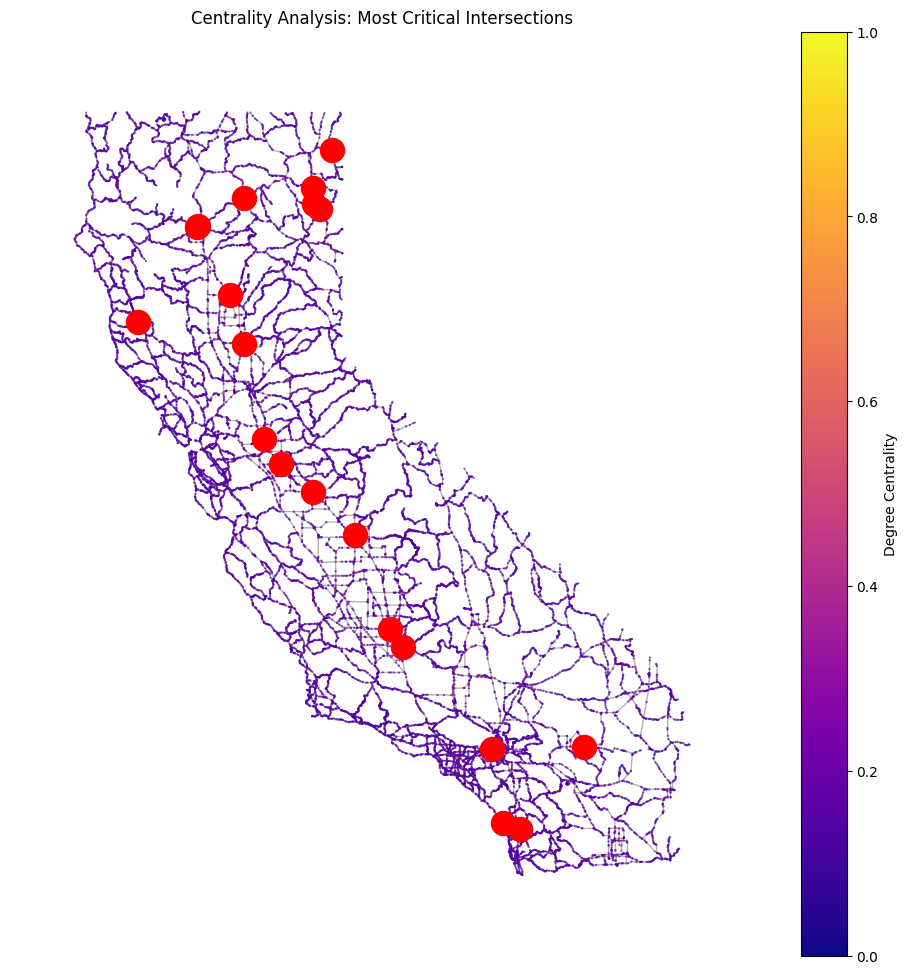

In [18]:
# Draw the graph
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(
    G, pos, node_size=node_size, with_labels=False, edge_color="gray", alpha=0.6, 
    node_color=list(degree_centrality.values()), cmap=plt.cm.plasma
)

# Highlight the top 10 most critical intersections
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]
nx.draw_networkx_nodes(G, pos, nodelist=top_nodes, node_color="red", node_size=300)

plt.title("Centrality Analysis: Most Critical Intersections")
fig.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.plasma), ax=ax, label="Degree Centrality")
plt.show()

### Community Detection - Louvain Community Detection

/var/folders/6d/ltzrn7zj535gpgr2_9hj9qn40000gn/T/ipykernel_15245/2420451779.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab10", len(unique_communities))


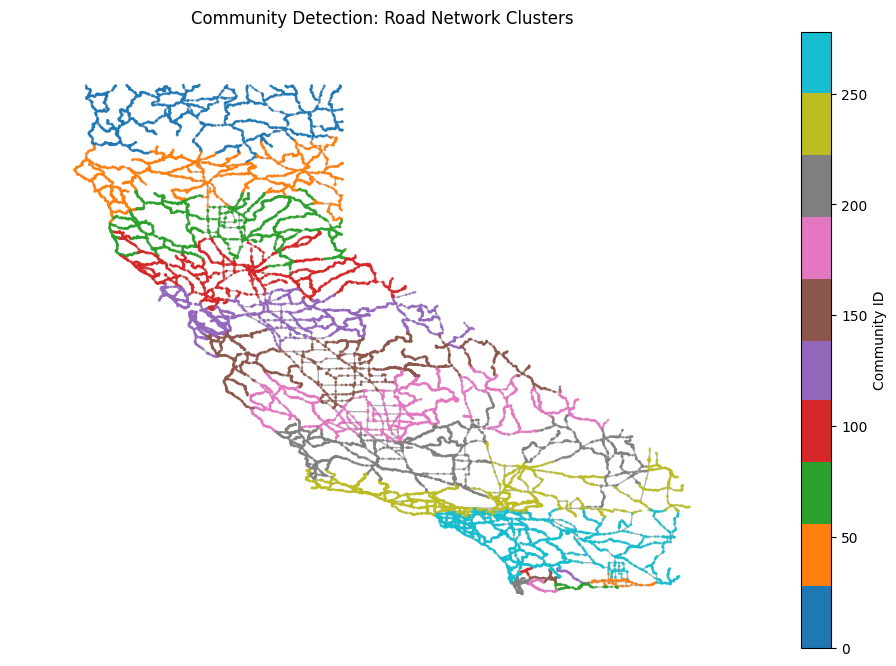

In [19]:
import community as community_louvain

# Apply Louvain Community Detection
partition = community_louvain.best_partition(G, weight='weight')

# Convert the partition dictionary to a dataframe for visualization
partition_df = pd.DataFrame(list(partition.items()), columns=["node", "community"])


# Assign each node a community color
unique_communities = sorted(set(partition.values()))  # Ensure order consistency
color_map = cm.get_cmap("tab10", len(unique_communities))

# Create a mapping from community ID to color
community_norm = mcolors.Normalize(vmin=min(unique_communities), vmax=max(unique_communities))
node_colors = [color_map(community_norm(partition[n])) if n in partition else (0, 0, 0, 1) for n in G.nodes()]

# Create figure and axes explicitly
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the network graph
nx.draw(G, pos, node_color=node_colors, with_labels=False, edge_color="gray", alpha=0.6, node_size=1, ax=ax)

# Add colorbar with explicit axes
sm = cm.ScalarMappable(cmap=color_map, norm=community_norm)
cbar = fig.colorbar(sm, ax=ax, label="Community ID")

plt.title("Community Detection: Road Network Clusters")
plt.show()

In [20]:
from collections import Counter
import random

# Function to compute shortest paths using Dijkstra's algorithm
def approximate_shortest_paths(graph, sample_size=0.5):
    """
    Computes approximate shortest paths by sampling a subset of the graph.
    :param graph: NetworkX graph
    :param sample_size: Fraction of nodes to keep in the sparsified graph
    :return: Dictionary of approximate shortest paths
    """
    sampled_nodes = set(random.sample(list(graph.nodes()), int(len(graph) * sample_size)))
    subgraph = graph.subgraph(sampled_nodes).copy()

    shortest_paths = {}
    for node in sampled_nodes:
        shortest_paths[node] = nx.single_source_dijkstra_path(subgraph, node)
    
    return shortest_paths

In [21]:
# Compute shortest paths
shortest_paths = approximate_shortest_paths(G, sample_size=0.3)

In [22]:
# Analyze edge usage frequency in shortest paths

edge_usage = Counter()

for source, paths in shortest_paths.items():
    for target, path in paths.items():
        # Process only sampled paths
        for i in range(len(path) - 1):
            edge = tuple(sorted((path[i], path[i+1])))  # Ensure edge order consistency
            edge_usage[edge] += 1


In [23]:
# Identify most congested edges (highest usage count)
most_congested_edges = sorted(edge_usage.items(), key=lambda x: x[1], reverse=True)

In [39]:
most_congested_edges[:10]

[((np.float64(13621.0), np.float64(13631.0)), 42),
 ((np.float64(13621.0), np.float64(13632.0)), 42),
 ((np.float64(17451.0), np.float64(17455.0)), 40),
 ((np.float64(17454.0), np.float64(17455.0)), 36),
 ((np.float64(17451.0), np.float64(17452.0)), 36),
 ((np.float64(13617.0), np.float64(13621.0)), 32),
 ((np.float64(13630.0), np.float64(13631.0)), 32),
 ((np.float64(13619.0), np.float64(13632.0)), 32),
 ((np.float64(17447.0), np.float64(17454.0)), 28),
 ((np.float64(17452.0), np.float64(17478.0)), 28)]

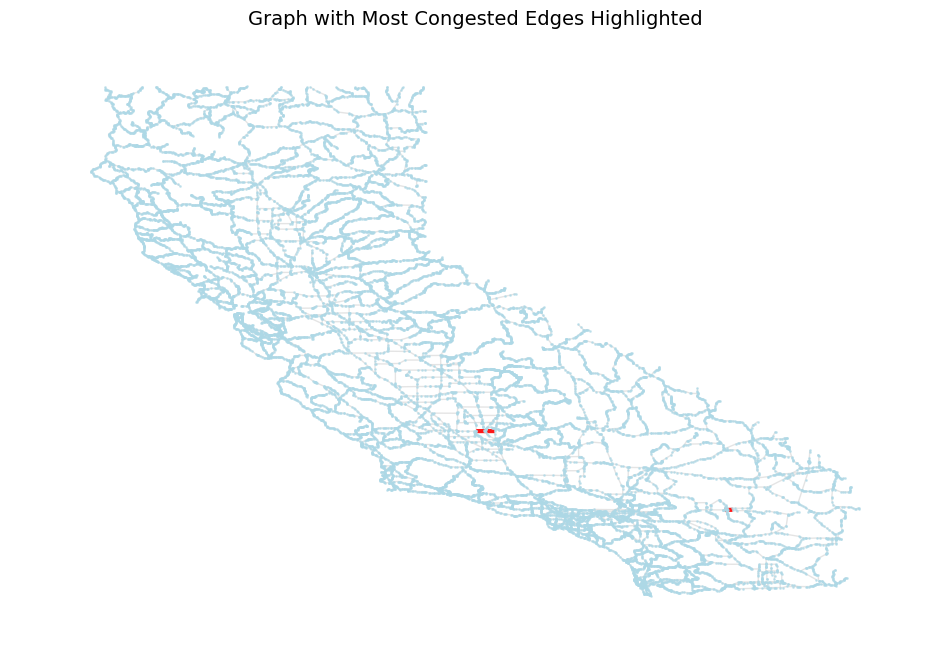

Most congested edges (high traffic routes):
Edge (np.float64(13621.0), np.float64(13631.0)) used 42 times in shortest paths
Edge (np.float64(13621.0), np.float64(13632.0)) used 42 times in shortest paths
Edge (np.float64(17451.0), np.float64(17455.0)) used 40 times in shortest paths
Edge (np.float64(17454.0), np.float64(17455.0)) used 36 times in shortest paths
Edge (np.float64(17451.0), np.float64(17452.0)) used 36 times in shortest paths
Edge (np.float64(13617.0), np.float64(13621.0)) used 32 times in shortest paths
Edge (np.float64(13630.0), np.float64(13631.0)) used 32 times in shortest paths
Edge (np.float64(13619.0), np.float64(13632.0)) used 32 times in shortest paths
Edge (np.float64(17447.0), np.float64(17454.0)) used 28 times in shortest paths
Edge (np.float64(17452.0), np.float64(17478.0)) used 28 times in shortest paths


In [58]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

most_congested_edges_set = {(int(edge[0]), int(edge[1])) for edge, _ in most_congested_edges[:10]}

fig, ax = plt.subplots(figsize=(12, 8))

nx.draw(G, pos, node_color='lightblue', with_labels=False, edge_color="lightgray", alpha=0.6, node_size=1, ax=ax)

edge_colors = []
edge_widths = []
highlighted_edges = []

for edge in G.edges():
    edge_tuple = (int(edge[0]), int(edge[1])) 
    if edge_tuple in most_congested_edges_set:
        highlighted_edges.append(edge)
    else:
        edge_colors.append("gray")
        edge_widths.append(0.8)

nx.draw_networkx_edges(G, pos, edgelist=highlighted_edges, edge_color="red", width=3, alpha=0.9, ax=ax)

plt.title("Graph with Most Congested Edges Highlighted", fontsize=14)
plt.show()

print("Most congested edges (high traffic routes):")
for edge, count in most_congested_edges[:10]:
    print(f"Edge {edge} used {count} times in shortest paths")
